In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from utils.model import hill_activation, hill_activation_and, random_search
from utils.helper import setup_header, read_map, read_dict, generate_data, \
                         get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected
from utils.plotter import plot_heatmap

In [92]:
hill_params_ = {
    'ara': [1.74213810e+00, 1.92163443e+00, 2.48731093e-17, 1.68274592e+01],
    'ohc14': [2.68637679e+01, 3.76978371e+00, 2.31765735e-20, 3.89971454e+00],
    'cuma': [6.44098873e+01, 1.12631909e+00, 7.78353057e-30, 2.20420592e+00],
    'oc6': [4.45528659e-01, 6.66698570e-01, 4.58799269e-15, 7.89302600e+00],
    'dapg': [6.30648958e-01, 1.82456281e+00, 1.94172402e-22, 1.16856181e+01],
    'sal': [2.05252519e+02, 1.21884003e+00, 3.50027356e-25, 8.20826000e+00],
    'rha': [1.79586835e+03, 1.38299926e+00, 1.00000000e-01, 1.25652670e+01]
}

In [109]:
aras_gate = [0, 0.8125, 3.25, 13, 52, 208]
aras = [0.012695313, 0.05078125, 0.203125, 0.8125, 3.25, 13]
cumas_gate = [0, 6.25, 12.5, 25, 50, 100]
ohc14s = [0, 10, 20, 40, 80, 160]
sals = [0, 6.25, 12.5, 25, 50, 100]
aras_rpu = np.round([hill_activation(i, *hill_params_['ara']) for i in aras_gate], 2)
aras_rpu2 = np.round([hill_activation(i, *hill_params_['ara']) for i in aras], 2)
cumas_rpu = np.round([hill_activation(i, *hill_params_['cuma']) for i in cumas_gate], 2)
ohc14s_rpu = np.round([hill_activation(i, *hill_params_['ohc14']) for i in ohc14s], 2)
sals_rpu = np.round([hill_activation(i, *hill_params_['sal']) for i in sals], 2)

In [87]:
folder = '033-all-and-gates-characterization'
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
gate_map = {
    'e11': 'e11x32STPhoRadA', 'e15': 'e15x32NpuSspS2', 'e16': 'e16x33NrdA2',
    'e20': 'e20x32gp411', 'e32': 'e32x30SspGyrB', 'e34': 'e34x30MjaKlbA',
    'e38': 'e38x32gp418', 'e41': 'e41x32NrdJ1', 'e42': 'e42x32STIMPDH1'
}
sample_dict = read_dict(pd.read_csv('datasets/dictionary.csv'))

In [30]:
heatmaps = []
responses = []
h = 10
timepoint = 3 * h
rpu = True

for i in tqdm(range(1, 6)):
    
    raw_data = setup_header(pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}.csv'.format(folder, i)))
    sample_map = read_map(pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}_map.csv'.format(folder, i)),
                     sample_dict)
    
    group = 'A'
    contents = ['Sample', 'Blank', 'Negative control']
    all_datas = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_datas.append(datas)
        
    group = 'B'
    contents = ['Positive control', 'Blank', 'Negative control']
    all_ctrls = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_ctrls.append(datas)
        
    fluo_idx, od_idx = 3, 0
    if rpu:
        samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]],
                                         [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                          all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
    else:
        samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]])
    samples_t = samples.iloc[timepoint]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2]
        fluo_t['ara'] = fluo_t['name'].str[-1]
        responses.append((gate, fluo_t))
        
        fluo_pvt = fluo_t.drop('name', axis=1).pivot('cuma', 'ara')
        fluo_pvt.index = cumas_rpu
        fluo_pvt.columns = aras_rpu
        heatmaps.append((gate, fluo_pvt))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


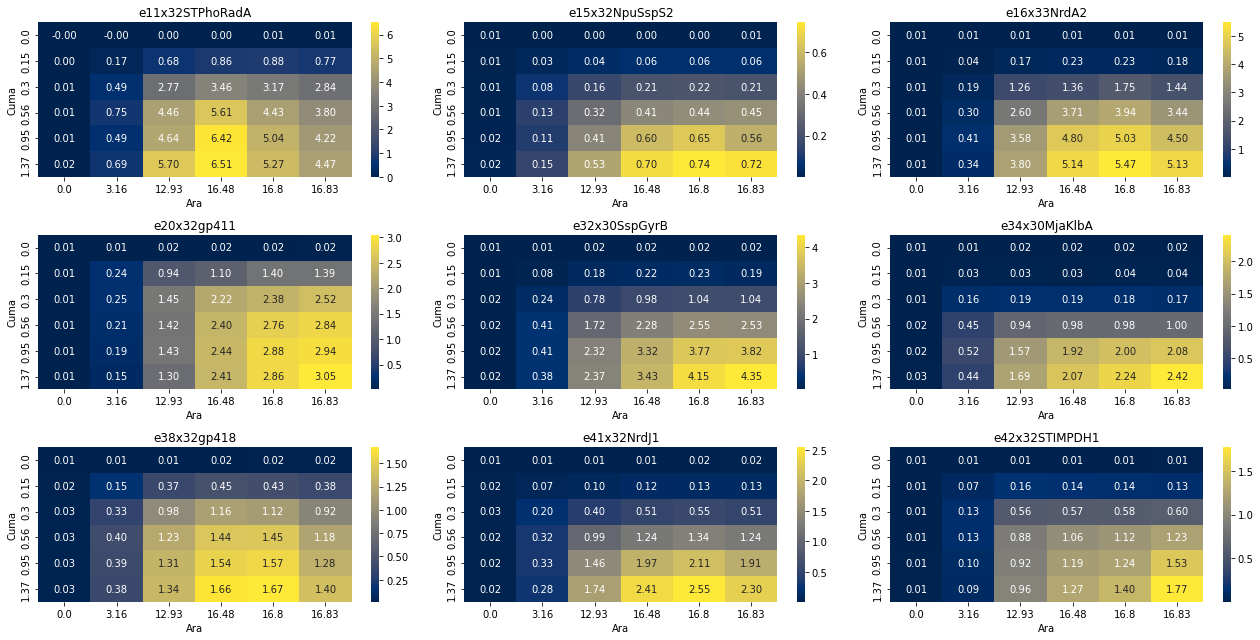

In [32]:
plot_heatmap(heatmaps, 3, 3, 'Ara', 'Cuma')

In [57]:
def hill(x, K, n):
    
    return x**n / (K**n + x**n)

def splicing(a, d, n, c):
    
    return a * n * c / d

def induction(b, a, d, x, K, n):

    return (b + a * hill(x, K, n)) / d

def new_hill_activation_and(x, bn, an, dn, K1, n1, bc, ac, dc, K2, n2, ae, de, bg, ag, dg, K3, n3):
    
    x1, x2 = x
    e_n = induction(bn, an, dn, x1, K1, n1)
    e_c = induction(bc, ac, dc, x2, K2, n2)
    ecf = splicing(ae, de, e_n, e_c)
    gfp = induction(bg, ag, dg, ecf, K3, n3)
    
    return gfp

e11x32STPhoRadA [1.92131128e-26 9.97772641e+02 2.04210015e+02 1.00000000e+00
 1.00000000e+00 3.70518845e-31 9.97835478e+02 7.21414628e+02
 4.00000000e+00 4.00000000e+00 5.51814455e+02 3.05596752e+02
 9.97260174e-29 8.19404679e+02 1.69924934e+02 2.13309357e+00
 4.00000000e+00] 0.8484896918773981
e15x32NpuSspS2 [4.44217763e+01 7.88056196e+02 4.37710646e+02 1.00000000e+00
 1.00000000e+00 1.19284651e-36 7.54093255e+02 4.26779502e+02
 4.00000000e+00 4.00000000e+00 7.03248588e+02 5.36655332e+02
 7.00136878e+00 4.50736929e+02 8.72026820e+02 1.03785083e+00
 4.00000000e+00] 0.7546625903831266
e16x33NrdA2 [9.39670579e+00 9.10508970e+02 3.09347824e+02 1.00000000e+00
 1.00000000e+00 8.88689480e-40 9.35742256e+02 3.11773310e+02
 4.00000000e+00 4.00000000e+00 4.46731849e+02 3.32703848e+02
 7.95939993e-38 5.23524320e+02 1.29172419e+02 2.55267706e+00
 4.00000000e+00] 0.7746008410848854
e20x32gp411 [8.42798703e-54 9.98276508e+02 4.97529656e+02 1.00000000e+00
 1.62083832e+00 2.44213749e-31 6.81907921e+0

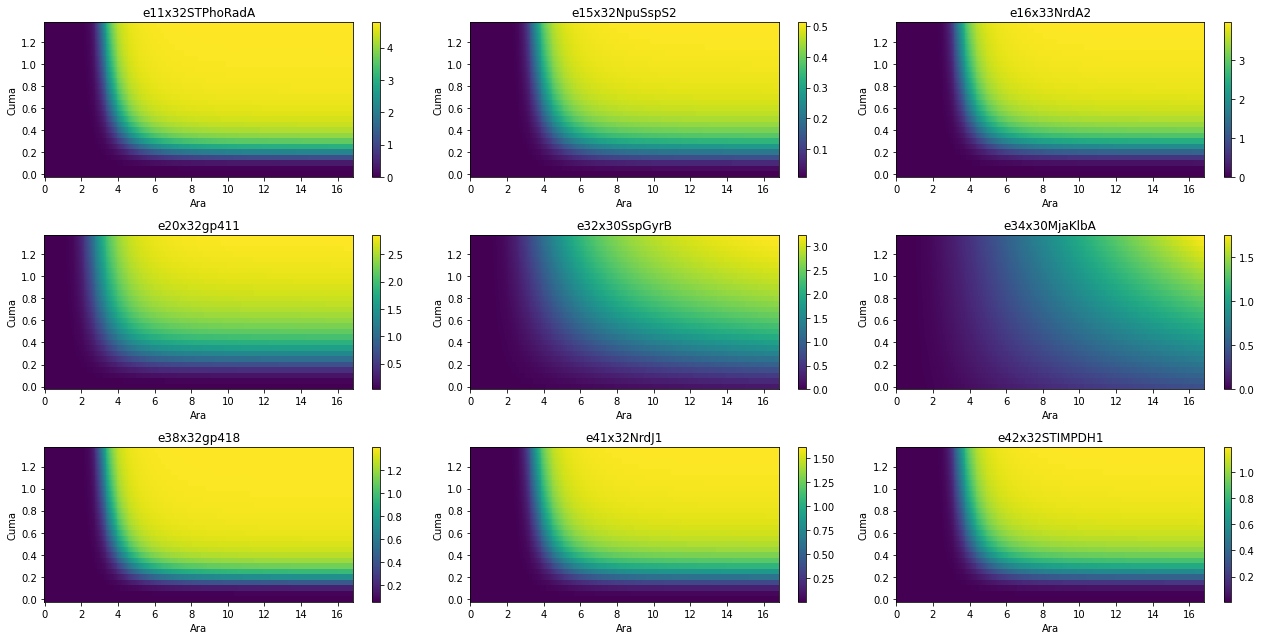

In [94]:
def plot_colormap(responses, gates, num_row, num_col, ind1, ind2):
    
    hill_params = {}
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(18, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            
            fluos = responses[i][1].set_index('name').iloc[:, 0]

            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            #fluo_t = fluo.reset_index().rename(columns={'index': 'gate'})
            #fluo_t['cuma'] = fluo_t['gate'].str[-2]
            #fluo_t['ara'] = fluo_t['gate'].str[-1]
            #fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
            #fluo_pvt.index = row_lbl
            #fluo_pvt.columns = col_lbl
            #sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=ax, cmap='cividis')
            
            #print(fluo_t[])
            #break
            
            x1, x2 = np.meshgrid(ind1, ind2)
            x = np.vstack((x1.ravel(), x2.ravel()))
            y = np.abs(fluo.values)
            #init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
            #gate_bounds = [[0, 0, 0, 0, 0, 0, 0, 0],
            #               [1e3, 1e3, 4, 4, y.min()+0.2*y.min(), y.min()+0.2*y.min(), y.max()+0.5*y.max(), y.max()+0.5*y.max()]]
            
            gate_bounds = [[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                            [1e3, 1e3, 1e3, 4, 4, 1e3, 1e3, 1e3, 4, 4, 1e3, 1e3, 1e3, 1e3, 1e3, 4, 4]]
            
            #print(gate_bounds)
            
            init_guess = random_search(30, x, y, gate_bounds, new_hill_activation_and)
            popt, pcov = curve_fit(new_hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
            
            y_pred = new_hill_activation_and(x, *popt)
            print(gate, popt, r2_score(y, y_pred))
            hill_params[gate] = popt
            
            arr_ind1 = np.arange(0, np.max(ind1), 0.05)
            arr_ind2 = np.arange(0, np.max(ind2), 0.05)
            x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
            x_ = np.vstack((x1_.ravel(), x2_.ravel()))
            y_pred_ = new_hill_activation_and(x_, *popt)
            
            cf = ax.pcolormesh(x2_, x1_, y_pred_.reshape(-1, len(arr_ind1)), cmap='viridis')
            f.colorbar(cf, ax=ax)
            #plt.clim(0, 5)
            #ax.axvline(h, color='red')
            #ax.axhline(h, color='red')
            
            #ax.axvline(0.01866272721909743, color='red')
            #ax.axvline(1.365845205649679e-12, color='red')
            #ax.axvline(3.575023694350424e-27, color='red')
            #ax.axvline(2.9144583244448006e-14, color='red')
            #ax.axvline(1.302244740421529, color='red')
            #ax.axvline(1.8474063001429318e-17, color='red')
            #ax.axvline(0.1215231788079449, color='red')
            
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
    return hill_params

hill_params = plot_colormap(responses, gates, 3, 3, cumas_rpu, aras_rpu)

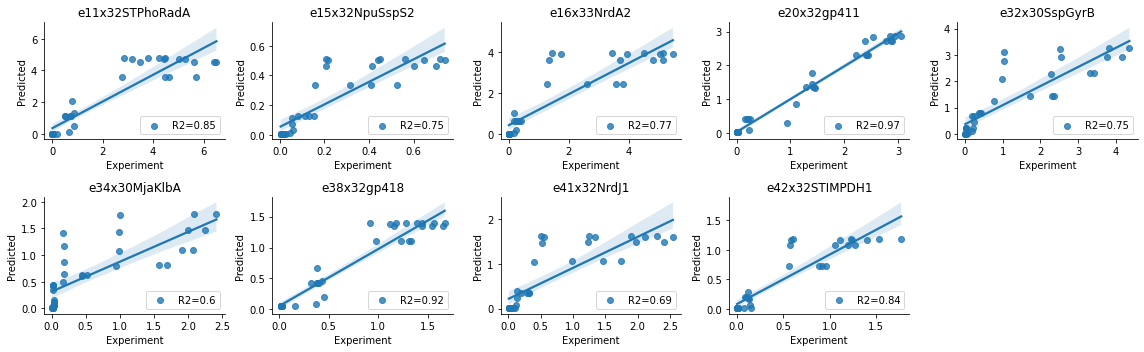

In [95]:
def plot_prediction(responses, gates, row, col, hill_params, cumas, aras):
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(16, 5))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            popt = hill_params[gate]
            fluos = responses[i][1].set_index('name').iloc[:, 0]

            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            y = np.abs(fluo.values)
            
            pred = new_hill_activation_and(x, *popt)
            sns.regplot(y, pred, ax=ax, label='R2={}'.format(round(r2_score(y, pred), 2)))
            ax.set_title(gates[i])
            ax.set_xlabel('Experiment')
            ax.set_ylabel('Predicted')
            ax.legend(loc=4)
            sns.despine()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    
plot_prediction(responses, gates, 2, 5, hill_params, cumas_rpu, aras_rpu)

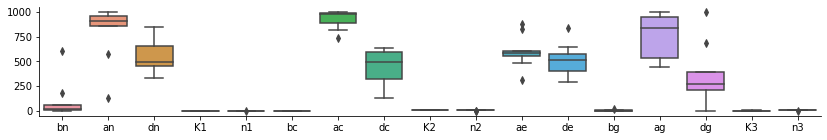

In [82]:
plt.figure(figsize=[14, 2])
df_params = pd.DataFrame(hill_params).T.round(3)
df_params.columns = ['bn', 'an', 'dn', 'K1', 'n1', 'bc', 'ac', 'dc', 'K2', 'n2', 'ae', 'de', 'bg', 'ag', 'dg', 'K3', 'n3']
sns.boxplot(data=df_params)
#plt.yscale('log')
sns.despine()

In [189]:
max_induction = [aras_rpu2[-1], ohc14s_rpu[-1], sals_rpu[-1]]
input_states = [format(x, '0{}b'.format(3)) for x in list(range(8))]
expected = [[a*int(b) for a, b in zip(max_induction, i)] for i in input_states]
expected

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 2.41],
 [0.0, 3.9, 0.0],
 [0.0, 3.9, 2.41],
 [16.48, 0.0, 0.0],
 [16.48, 0.0, 2.41],
 [16.48, 3.9, 0.0],
 [16.48, 3.9, 2.41]]

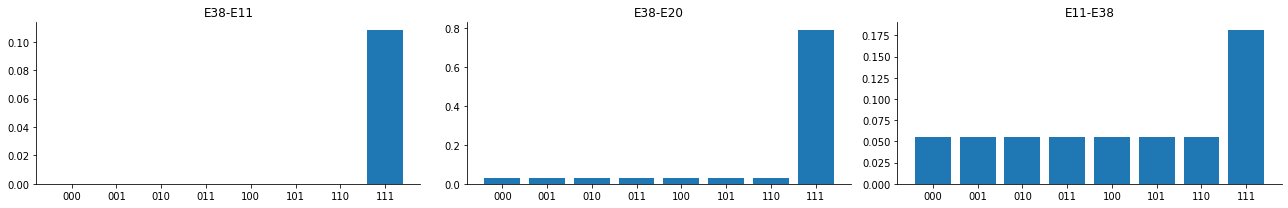

In [196]:
arrs = [['e38', 'e11'], ['e38', 'e20'], ['e11', 'e38']]
row, col = 1, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(arrs):
        arr = arrs[i]
        output = []
        for e in expected:
            g1 = new_hill_activation_and((e[1], e[0]), *hill_params[gate_map[arr[0]]])
            g2 = new_hill_activation_and((g1, e[2]), *hill_params[gate_map[arr[1]]])
            output.append(g2)
        ax.bar(input_states, output)
        ax.set_title('-'.join(arr).upper())
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [129]:
gate = 'e11'
max_induction = [aras_rpu[-1], cumas_rpu[-1]]
input_states = [format(x, '0{}b'.format(2)) for x in list(range(4))]
expected = [[a*int(b) for a, b in zip(max_induction, i)] for i in input_states]
expected

[[0.0, 0.0], [0.0, 1.37], [16.83, 0.0], [16.83, 1.37]]

e11x32STPhoRadA


e11x32STPhoRadA
e15x32NpuSspS2
e16x33NrdA2
e20x32gp411
e32x30SspGyrB
e34x30MjaKlbA
e38x32gp418
e41x32NrdJ1
e42x32STIMPDH1


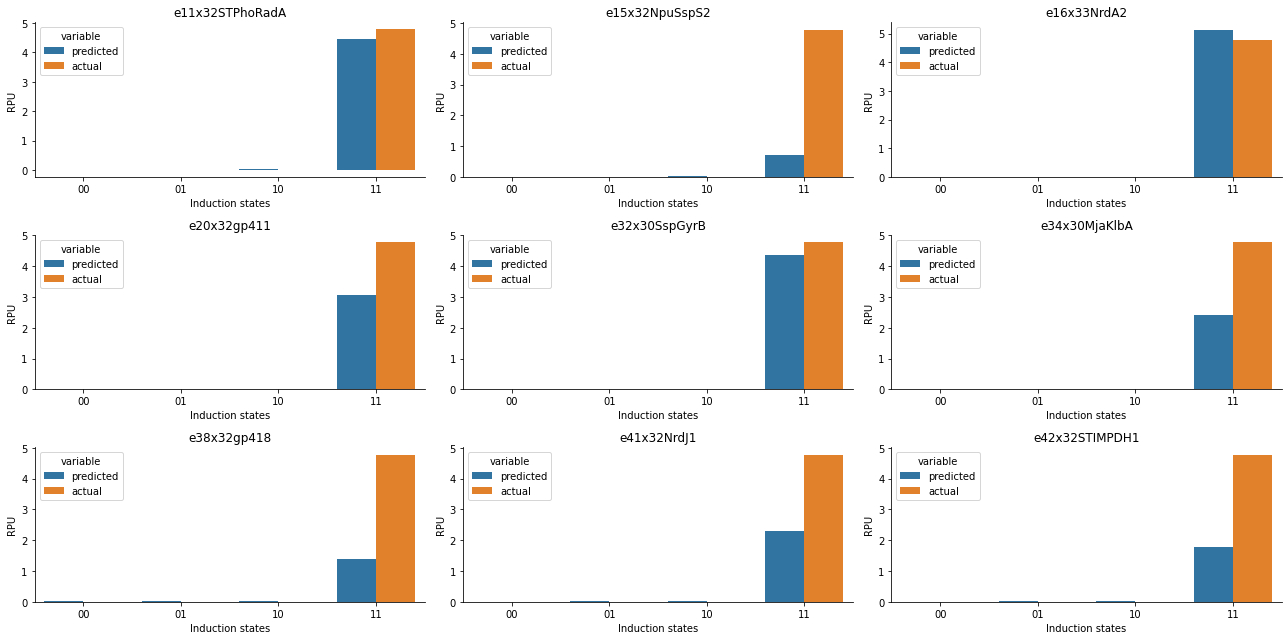

In [188]:
def plot_responses(responses, row=3, col=3, xlabel='Induction states', ylabel='RPU'):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(responses):
            gate_idx = i
            datar = responses[gate_idx][1]
            print(responses[gate_idx][0])
            y = datar[((datar['cuma']=='0') | (datar['cuma']=='5')) & ((datar['ara']=='0') | (datar['ara']=='5'))].iloc[:, 1].reset_index(drop=True)
            data = pd.concat([y, pd.DataFrame(output)], axis=1)
            data.columns = ['predicted', 'actual']
            data = data.melt()
            data['x'] = ['00', '01', '10', '11', '00', '01', '10', '11']
            sns.barplot(data=data, x='x', y='value', hue='variable', ax=ax)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(responses[gate_idx][0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
plot_responses(responses)

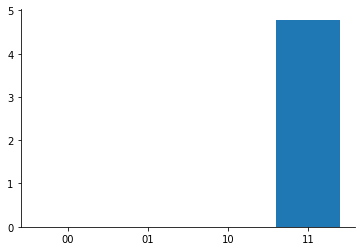

In [146]:
arr = ['e11']
output = []
for e in expected:
    g1 = new_hill_activation_and((e[1], e[0]), *hill_params[gate_map[arr[0]]])
    output.append(g1)
plt.bar(input_states, output)
sns.despine()